In [30]:
%matplotlib inline
import matplotlib
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [31]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [32]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [16]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [17]:
insp = inspect(engine)
print(insp.get_table_names())

['measurement', 'station']


In [18]:
# reflect an existing database into a new model
# reflect the tables
Base = automap_base()
Base.prepare(autoload_with=engine)
Base.classes.keys()


['measurement', 'station']

In [19]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [20]:
# Save references to each table
M = Base.classes.measurement
S = Base.classes.station

In [21]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [22]:
# Find the most recent date in the data set.
recent_date = session.query(M.date).order_by(M.date.desc()).first()
print(recent_date)

('2017-08-23',)


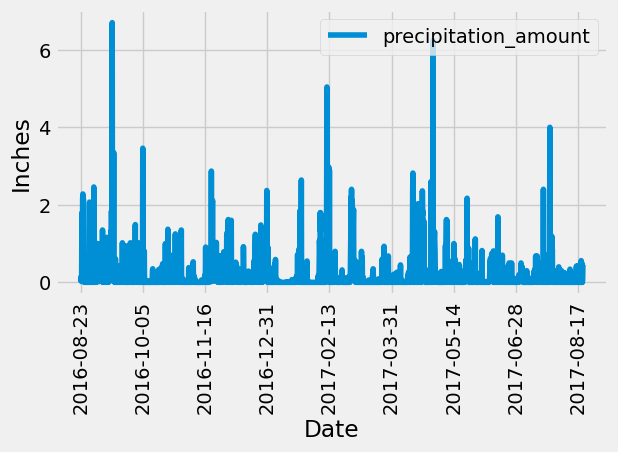

In [58]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
data_query = dt.datetime.strptime(recent_date[0], '%Y-%m-%d')
date_query = dt.date(data_query.year -1, data_query.month, data_query.day)
date_query

# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame. Explicitly set the column names
sel =[M.date, M.prcp]
precipitation_query = session.query(*sel).\
    filter(M.date >= date_query).\
    order_by(M.date).all()
        

precipitation = pd.DataFrame(precipitation_query, columns = ['measurement_date', 'precipitation_amount'])
precipitation.dropna(how='any', inplace=True)

# Sort the dataframe by date
precipitation.sort_values(['measurement_date'], ascending=True)
precipitation.set_index('measurement_date', inplace=True)
# Use Pandas Plotting with Matplotlib to plot the data
ax = precipitation.plot(rot=90, xlabel='Date', ylabel = 'Inches')
plt.tight_layout()
plt.show()

In [59]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation.describe()

,precipitation_amount
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [65]:
# Design a query to calculate the total number of stations in the dataset
session.query(S).count()

9

In [68]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sel = [M.station,
      func.count(M.date)]
active =session.query(*sel).\
    group_by(M.station).\
    order_by(func.count(M.date).desc()).all()
active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [75]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [M.station, 
      func.min(M.tobs),
      func.max(M.tobs),
      func.avg(M.tobs)]
active_ss = session.query(*sel).\
    filter(M.station == 'USC00519281').\
    group_by(M.station).all()
active_ss

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

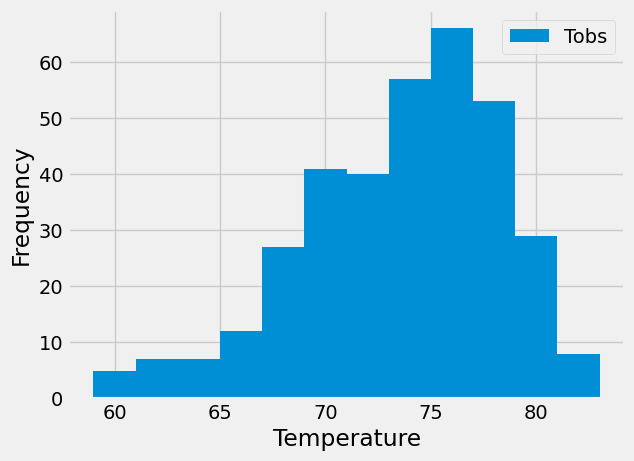

In [86]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [M.date,
      M.tobs]
temp = session.query(*sel).\
    filter(func.strftime(M.date) >= date_query, M.station == 'USC00519281').\
    group_by(M.date).\
    order_by(M.date).all()

temps_df = pd.DataFrame(temp, columns = ['measurement_date', 'temperature'])

temps_df.sort_values(['measurement_date'], ascending=True)
temps_df.set_index('measurement_date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data

plt.hist(temps_df['temperature'],bins=12, label='Tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Close Session

In [87]:
# Close Session
session.close()